## Introdução
O desafio é criar a base do sistema de IA focado em
machine learning, permitindo que resultados de exames sejam analisados
automaticamente e destacando informações relevantes para o diagnóstico.

## Tema escolhido
Predição de casos de AVC.

## Objetivo
Considerando que, no contexto de AVC, a maioria dos atendimentos resulta em diagnóstico negativo, 
o modelo de IA será orientado prioritariamente à identificação de pacientes com baixa probabilidade 
de AVC. Essa abordagem visa otimizar a triagem clínica, reduzindo a fila de espera para os casos 
com maior suspeita e, consequentemente, agilizando o acesso aos exames de 
imagem — Tomografia Computadorizada (TC) e Ressonância Magnética (RM) de Crânio — para 
os pacientes com maior risco.

#### Imports e carregamento de dados

In [1]:
# imports necessarios para o projeto
import kagglehub
import math
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd 
import seaborn as sns
from sklearn.model_selection import train_test_split

# Fazero download da ultima versao do dataset
path = kagglehub.dataset_download("shashwatwork/cerebral-stroke-predictionimbalaced-dataset")
print("Path to dataset files:", path)
os.listdir(path)

Path to dataset files: C:\Users\stefa\.cache\kagglehub\datasets\shashwatwork\cerebral-stroke-predictionimbalaced-dataset\versions\1


['dataset.csv']

In [2]:
file_path = f"{path}/dataset.csv"
df = pd.read_csv(file_path)

#### Primeira inspeção dos dados
Aqui iremos verificar o tamanho do dataset, tipo de variáveis, se existem valores nulos e qual a proporção de valores que iremos trabalhar.

In [3]:
#verificacao quantitativa de linhas e colunas
print("Dimensões do dataset: ", df.shape)
#visualizando topo da tabela
display(df.head())

Dimensões do dataset:  (43400, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [4]:
#Informações gerais do dataset (colunas, tipo de dado, contagem e etc)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 43400 non-null  int64  
 1   gender             43400 non-null  object 
 2   age                43400 non-null  float64
 3   hypertension       43400 non-null  int64  
 4   heart_disease      43400 non-null  int64  
 5   ever_married       43400 non-null  object 
 6   work_type          43400 non-null  object 
 7   Residence_type     43400 non-null  object 
 8   avg_glucose_level  43400 non-null  float64
 9   bmi                41938 non-null  float64
 10  smoking_status     30108 non-null  object 
 11  stroke             43400 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


In [5]:
# analise de descricao
df.groupby("stroke").describe()

id                                                               \
          count          mean           std   min      25%      50%      75%   
stroke                                                                         
0       42617.0  36317.641293  21075.614059   1.0  17997.0  36356.0  54507.0   
1         783.0  36788.836526  20890.023777  80.0  19798.5  36236.0  54865.5   

                     age             ... avg_glucose_level              bmi  \
            max    count       mean  ...               75%     max    count   
stroke                               ...                                      
0       72943.0  42617.0  41.741565  ...            111.67  291.05  41295.0   
1       72918.0    783.0  68.143448  ...            192.36  271.74    643.0   

                                                           
             mean       std   min   25%   50%   75%   max  
stroke                                                     
0       28.585371  7.788594  10.1  23.2  27.7  32.8  97.6  
1       29.868118  6.344873  14.3  25.7  29.1  33.0  56.6  

[2 rows x 48 columns]

In [6]:
# analise de valores nulos
df.isnull().sum()

id                       0
gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64

##### Avaliando a distribuição da variável stroke (AVC)

Distribuição numérica:
 stroke
0    42617
1      783
Name: count, dtype: int64


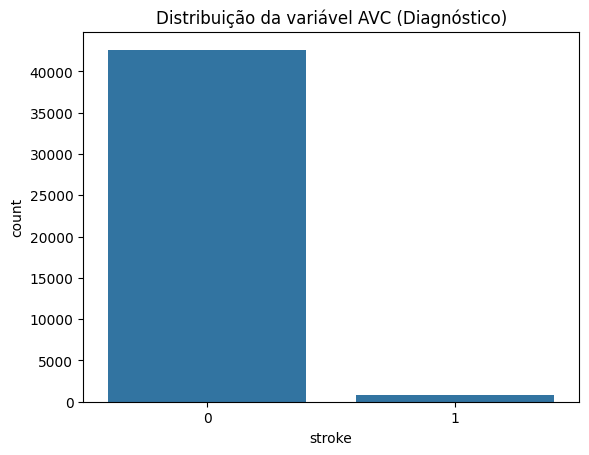

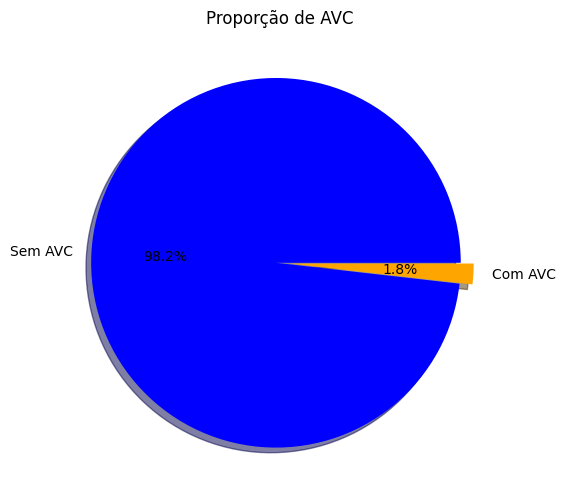

In [7]:
#variacao numerica
avc_count = df['stroke'].value_counts()
print("Distribuição numérica:\n",avc_count)

# exibindo em barras
sns.countplot(x='stroke', data=df)
plt.title('Distribuição da variável AVC (Diagnóstico)')
plt.show()

#exibindo a proporcao em porcentagem
plt.figure(figsize=(6,6))
plt.pie(avc_count.values, labels=['Sem AVC','Com AVC'], autopct='%1.1f%%', explode=(0.02,0.05), shadow=True, colors=['blue','orange'])
plt.title('Proporção de AVC')
plt.show();


Podemos notar que este é um dataset desbalanceado, pois a proporção de pessoas com AVC são baixos (Interessante para o trabalho por ter uma proximidade maior com relação a casos reais).

Nesta analise notamos que temos textos que deveram ser lidados para que o modelo possa ser treinado, temos também alguns dados nulos que terão que ser lidados.

Vamos fazer agora a remoção de colunas que não são necessárias como ID. Ajustes para os dados que são textos mantendo uma cópia do dataset original. E ajustar os valores nulos.

### Tratamento de dados

In [8]:
#removendo a coluna id
df.drop('id', axis=1, inplace=True)

#executando tratamento de colunas nulas 
# Vamos preencher o IMC com a media de acordo com o Genero e Idade seguindo abordando com o método de grupos
df['bmi'] = df['bmi'].fillna(df.groupby(['gender', 'age'])['bmi'].transform('mean'))

# Verifica se sobrou algum nulo após o tratamento por grupos
nulos_restantes = df['bmi'].isnull().sum()
if nulos_restantes > 0:
    print(f"Atenção: Sobraram {nulos_restantes} nulos no BMI. Preenchendo com a mediana geral.")
    df['bmi'] = df['bmi'].fillna(df['bmi'].median())
else:
    print("✅ BMI 100% preenchido!")


Atenção: Sobraram 4 nulos no BMI. Preenchendo com a mediana geral.


Fizemos a limpeza de dados nulos na coluna e IMC e mantivemos o status 'Unknown' na coluna Fumante para não enviesar o treinamento. Como essa lacuna de dados é grande, transformá-la em uma categoria permite que a IA identifique padrões por conta própria. Se a gente tentasse preencher ou apagar esses dados, estaríamos mascarando o impacto real do tabagismo no risco de AVC.


In [9]:
# realizando duplicata de df para poder preencher com numeros as colunas que sao de categorias
# Criando a cópia e aplicando o get_dummies para corrigir as categorias em texto.
# O drop_first=True evita a redundância estatística (multicolinearidade)
df_model = pd.get_dummies(df, drop_first=True)

# Verificando como as colunas ficaram
print(f"Colunas originais: {len(df.columns)}")
print(f"Colunas no df_model: {len(df_model.columns)}")
print("-" * 30)
print(df_model.columns.tolist())

Colunas originais: 11
Colunas no df_model: 16
------------------------------
['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke', 'gender_Male', 'gender_Other', 'ever_married_Yes', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban', 'smoking_status_never smoked', 'smoking_status_smokes']


### Exibindo gráficos para visualização geral dos dados individuais da colunas

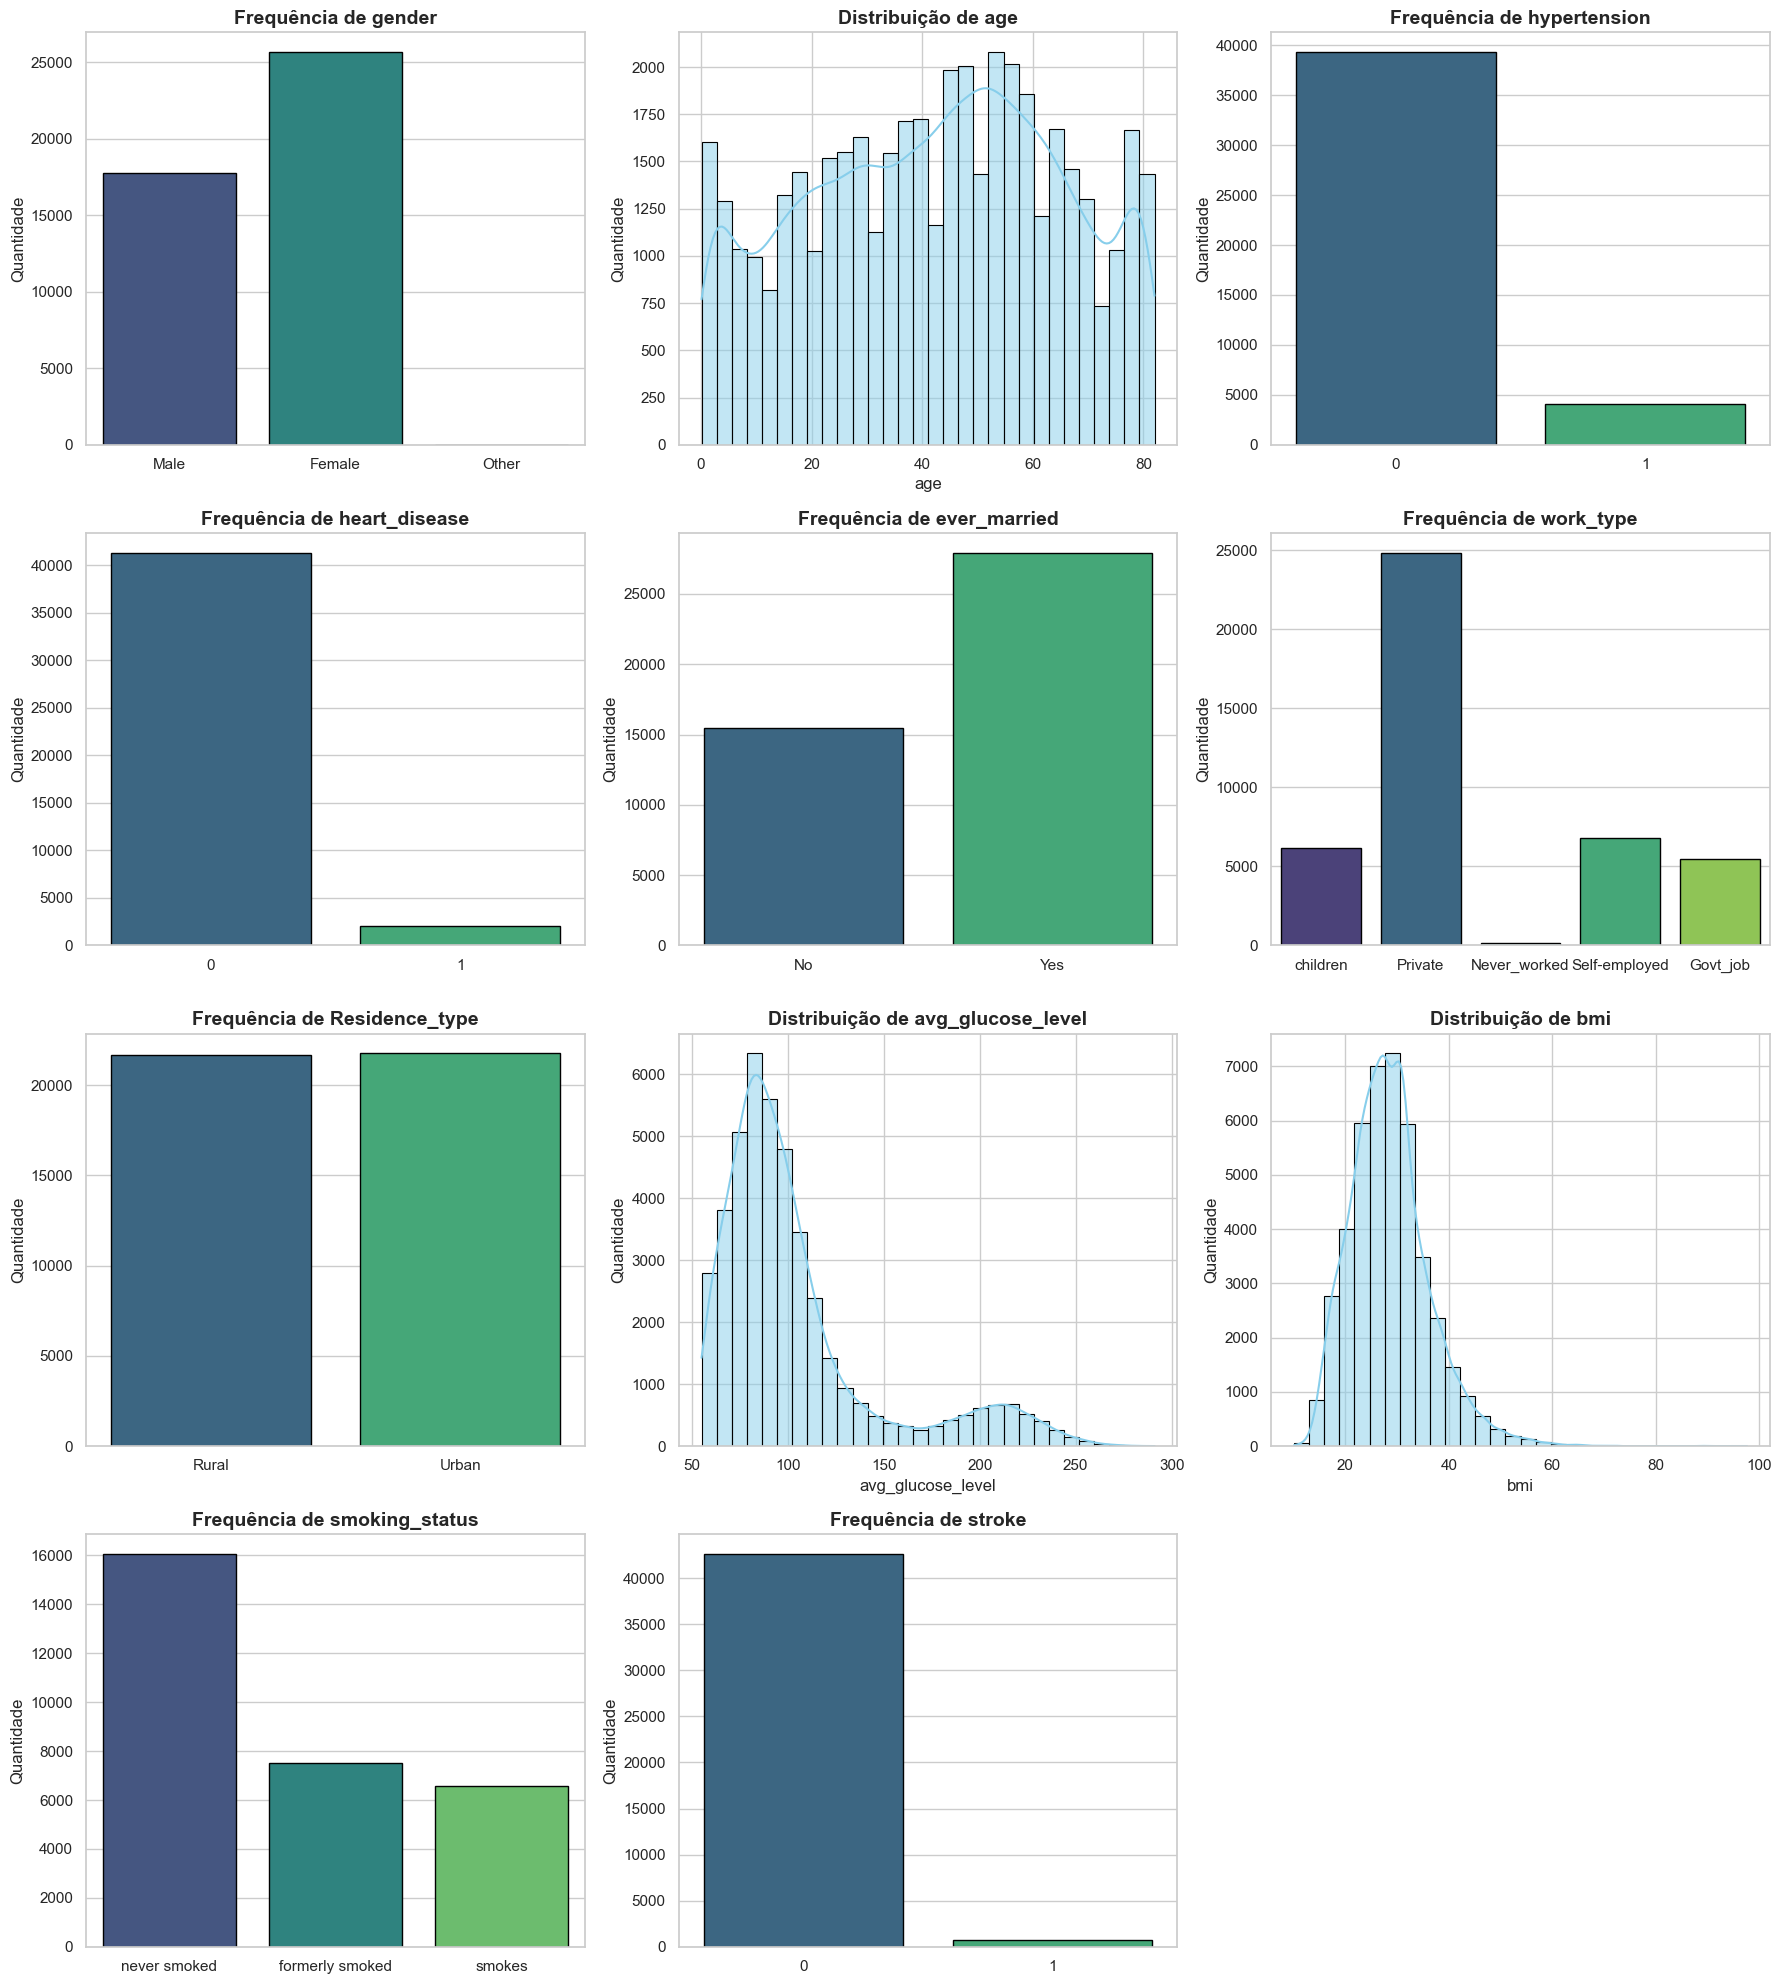

In [10]:
# 1. Definimos o dicionário de cores
cores_projeto = {0: "royalblue", 1: "darkorange"}

# 2. Configuramos o estilo e a paleta padrão
sns.set_theme(style="whitegrid")
sns.set_palette(list(cores_projeto.values()))

# 3. (Opcional) Ajuste fino para o Matplotlib usar essas cores por padrão
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=list(cores_projeto.values()))

# Usamos o df original para manter as legendas (Male, Female, Private, etc)
colunas = df.columns.tolist()
sns.set_theme(style="whitegrid")
n_cols = 3
n_rows = math.ceil(len(colunas) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for idx, col in enumerate(colunas):
    ax = axes[idx]
    
    # Se a coluna for numérica e tiver muitos valores (ex: age, bmi, glucose)
    if df[col].nunique() > 10 and df[col].dtype != 'object':
        sns.histplot(
            df[col].dropna(),
            bins=30,
            kde=True,
            color='skyblue',
            edgecolor='black',
            linewidth=0.8,
            ax=ax
        )
        ax.set_title(f'Distribuição de {col}', fontsize=14, fontweight='bold')
    
    # Se a coluna for categórica ou binária (ex: gender, hypertension, heart_disease, stroke)
    else:
        # Usamos countplot para manter o padrão visual do Seaborn
        sns.countplot(
            data=df, 
            x=col, 
            ax=ax, 
            palette='viridis', 
            edgecolor='black',
            hue=col,            # Adicionado para evitar avisos de futuras versões
            legend=False
        )
        ax.set_title(f'Frequência de {col}', fontsize=14, fontweight='bold')
        ax.set_xlabel('') # Limpa o label do eixo X para não repetir o título

    ax.set_ylabel('Quantidade')

# Remove eixos extras que ficarem em branco
for i in range(len(colunas), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

Nosso dataset foca nos principais fatores de risco como idade avançada, alta glicose, hipertensão e doenças do coração. A idade está bem distribuída, o que é um ponto forte para a IA mapear o risco ao longo do tempo. Embora os casos de AVC e doenças cardíacas sejam a minoria (o que é esperado e real), o equilíbrio geral dos outros dados favorece um treinamento eficaz e muito próximo da realidade clínica.

### Cruzando os dados: vamos ver como cada fator influencia o risco de AVC.

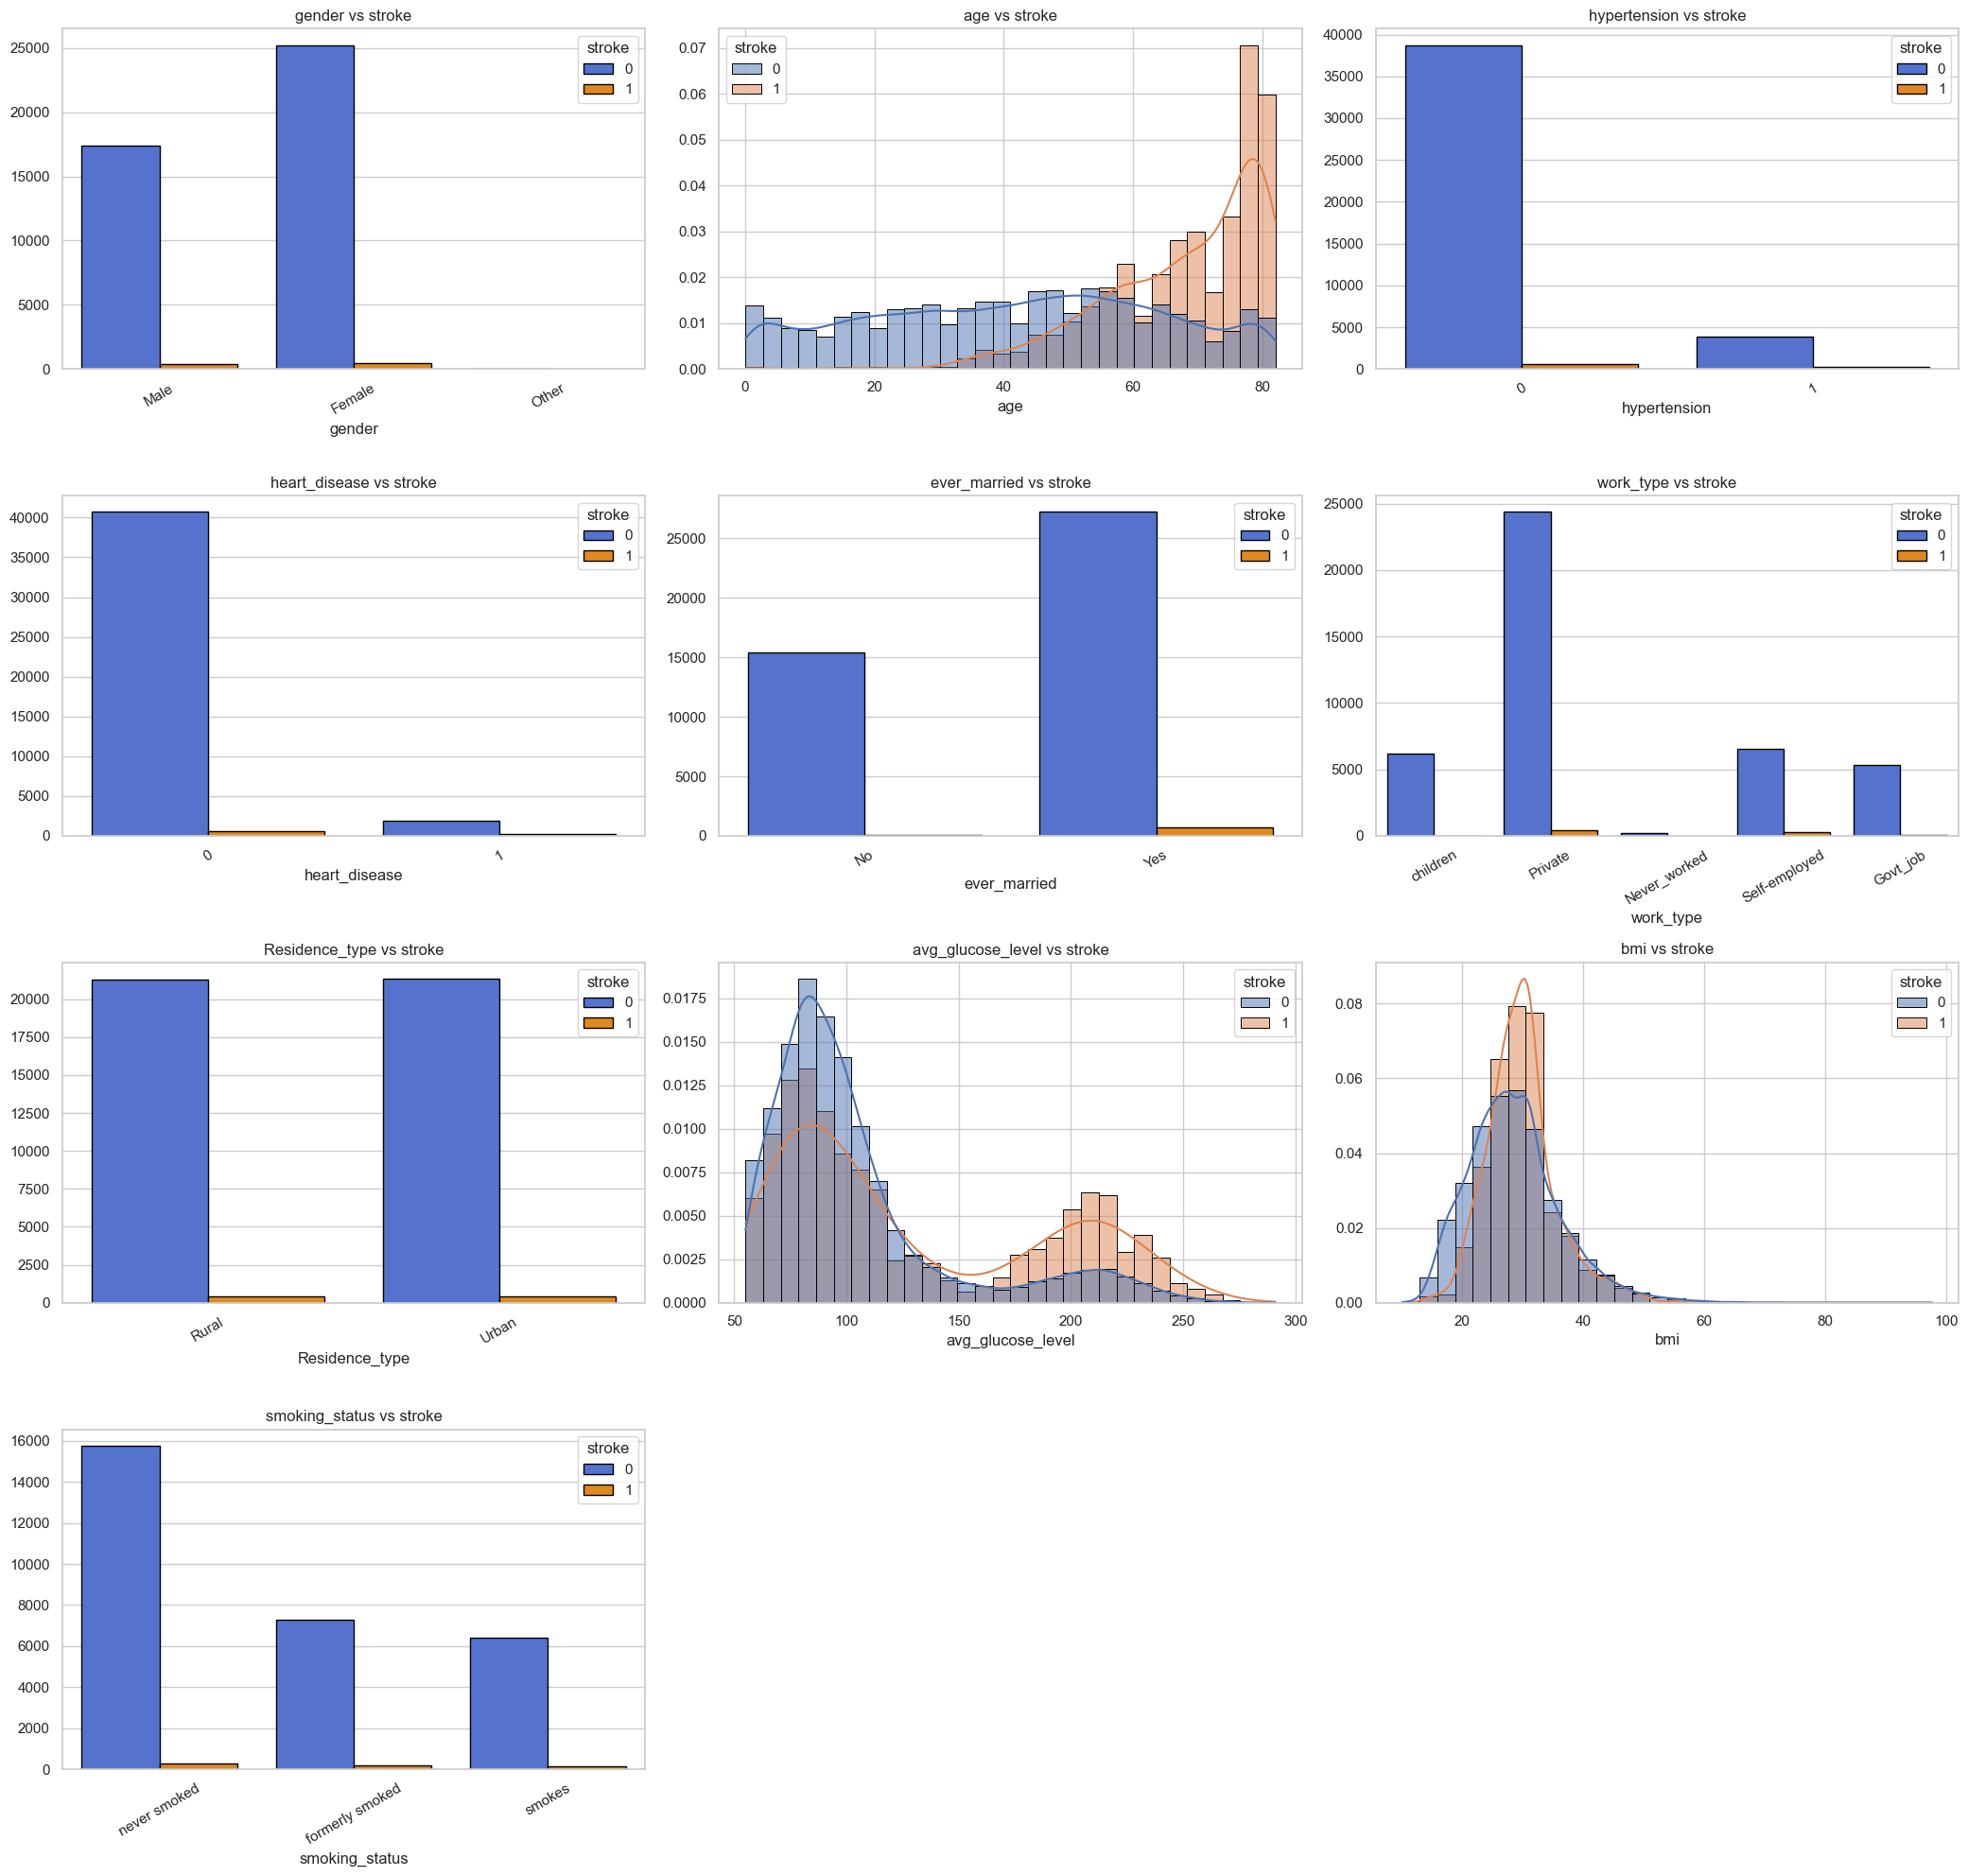

In [11]:
# Executando comparacao de todas as colunas do dataset com a coluna objetivo que é avc (stroke)
sns.set(style="whitegrid")

target = 'stroke'
features = [col for col in df.columns if col != target]

n_cols = 3
n_rows = math.ceil(len(features) / n_cols)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(7 * n_cols, 5 * n_rows)
)
axes = axes.flatten()

for idx, col in enumerate(features):
    ax = axes[idx]
    unique_vals = df[col].nunique()

    # Numéricas contínuas
    if df[col].dtype != 'object' and unique_vals > 10:
        sns.histplot(
            data=df,
            x=col,
            hue=target,
            bins=30,
            kde=True,
            stat='density',
            common_norm=False,
            edgecolor='black',
            linewidth=0.7,
            ax=ax
        )
        ax.set_title(f'{col} vs {target}')

    # Categóricas / binárias
    else:
        sns.countplot(
            data=df,
            x=col,
            hue=target,
            edgecolor='black',
            ax=ax,
            palette=cores_projeto
        )
        ax.set_title(f'{col} vs {target}')
        ax.tick_params(axis='x', rotation=30)

    
    ax.set_ylabel('')

# Remove eixos vazios
for i in range(len(features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

Visualizando os gráficos, identificamos uma forte relação entre Idade, glicose e IMC na detecção de casos reais de AVC, porem aparentemente a hipertensão que clinicamente é um dos fatores mais relevante não se destacou no dataset utilizado.


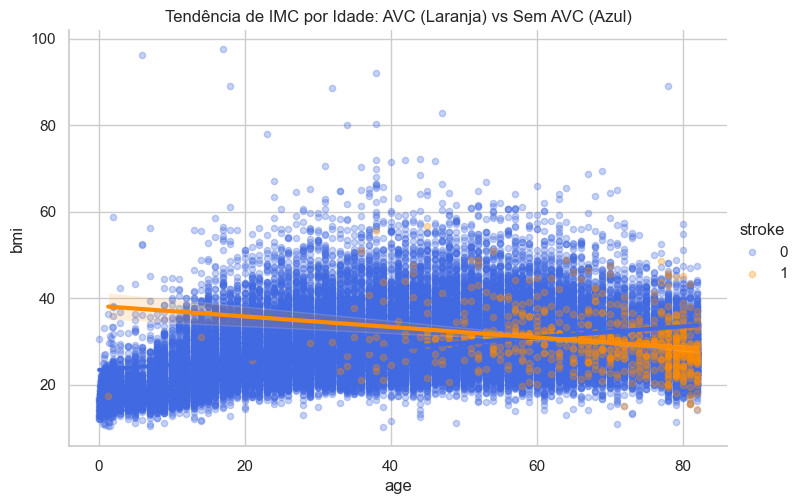

In [33]:
# Usamos o lmplot para gerar um gráfico com 3 informações(Idade, IMC e AVC) para exibir a correlação entre elas.
sns.lmplot(
    data=df, 
    x='age', 
    y='bmi', 
    hue='stroke', 
    palette=cores_projeto, 
    aspect=1.5,
    scatter_kws={'alpha': 0.3, 's': 20},
    line_kws={'linewidth': 3}
)

plt.title('Tendência de IMC por Idade: AVC (Laranja) vs Sem AVC (Azul)')
plt.show()

Nesse gráfico, confirmamos a forte relação entre Idade, IMC com a detecção de casos reais de AVC.

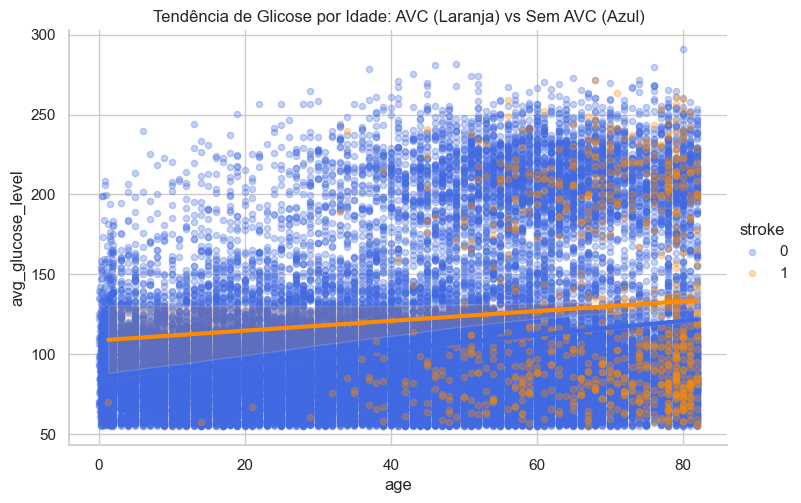

In [35]:
# Usamos o lmplot para gerar um gráfico com 3 informações(Idade, glicose e AVC) para exibir a correlação entre elas.
sns.lmplot(
    data=df, 
    x='age', 
    y='avg_glucose_level', 
    hue='stroke', 
    palette=cores_projeto, 
    aspect=1.5,
    scatter_kws={'alpha': 0.3, 's': 20},
    line_kws={'linewidth': 3}
)

plt.title('Tendência de Glicose por Idade: AVC (Laranja) vs Sem AVC (Azul)')
plt.show()

Aqui validamos a influência da Glicose e do IMC nos casos de AVC, notando uma particularidade na terceira idade: a variação nos níveis de açúcar no sangue é um forte indicador de risco. Destaca-se que, para os idosos, a glicose baixa aparece como um destaque importante.

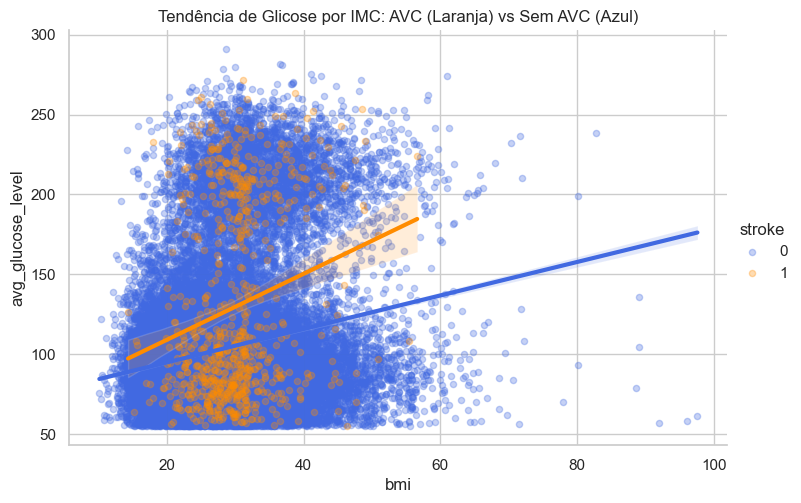

In [37]:
# Usamos o lmplot para gerar um gráfico com 3 informações(IMC, glicose e AVC) para exibir a correlação entre elas.
sns.lmplot(
    data=df, 
    x='bmi', 
    y='avg_glucose_level', 
    hue='stroke', 
    palette=cores_projeto, 
    aspect=1.5,
    scatter_kws={'alpha': 0.3, 's': 20},
    line_kws={'linewidth': 3}
)

plt.title('Tendência de Glicose por IMC: AVC (Laranja) vs Sem AVC (Azul)')
plt.show()

Ao observar o gráfico, percebe-se que a maioria dos dados se concentra no IMC entre 20 e 40, com a glicose variando principalmente entre 50-150 e 180-250. Nessas faixas, é possível identificar diversos casos de AVC. No entanto, o gráfico não mostra uma conexão direta ou muito forte entre o nível de glicose e o IMC em si.

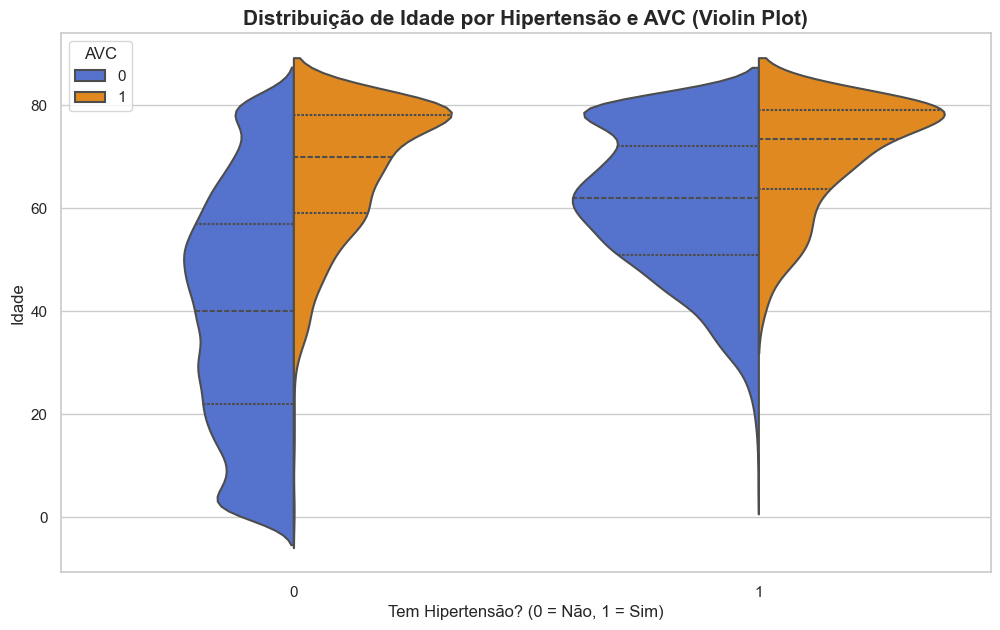

In [14]:
# Usamos o Violin Plot para gerar um gráfico com 3 informações(idade, hipertensão e AVC) para exibir a correlação entre elas.
plt.figure(figsize=(12, 7))

sns.violinplot(
    data=df, 
    x='hypertension', 
    y='age', 
    hue='stroke', 
    palette=cores_projeto,
    split=True,      
    inner="quartile",
    linewidth=1.5
)

plt.title('Distribuição de Idade por Hipertensão e AVC (Violin Plot)', fontsize=15, fontweight='bold')
plt.xlabel('Tem Hipertensão? (0 = Não, 1 = Sim)', fontsize=12)
plt.ylabel('Idade', fontsize=12)
plt.legend(title='AVC', loc='upper left')

plt.show()

A análise deste gráfico indica uma tendência de maior incidência de AVC em indivíduos com hipertensão e idade avançada, um padrão que não ficou evidente na análise cruzada simples. Para aprofundar nessa analise e confirmar a relevância dessas variáveis, será apresentado a seguir um gráfico de análise proporcional.

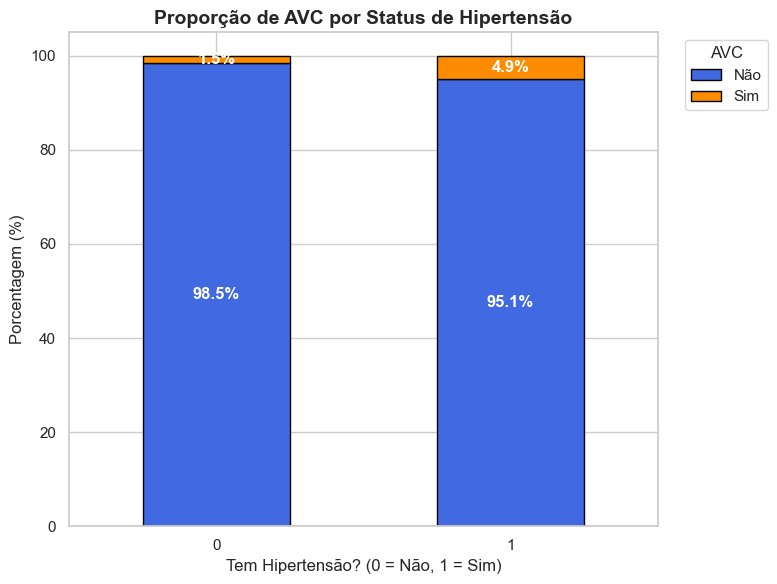

In [21]:
# Criando uma tabela de proporção
prop_data = pd.crosstab(df['hypertension'], df['stroke'], normalize='index') * 100

# Plotando o gráfico de barras empilhadas
ax = prop_data.plot(
    kind='bar', 
    stacked=True, 
    color=[cores_projeto[0], cores_projeto[1]], 
    figsize=(8, 6), 
    edgecolor='black'
)

plt.title('Proporção de AVC por Status de Hipertensão', fontsize=14, fontweight='bold')
plt.xlabel('Tem Hipertensão? (0 = Não, 1 = Sim)')
plt.ylabel('Porcentagem (%)')
plt.legend(title='AVC', labels=['Não', 'Sim'], loc='upper right', bbox_to_anchor=(1.2, 1))
plt.xticks(rotation=0)

# Adicionando os rótulos de porcentagem dentro das barras
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0:        
        ax.text(
            x + width/2, 
            y + height/2, 
            f'{height:.1f}%', 
            ha='center', 
            va='center', 
            color='white', 
            fontweight='bold',
            fontsize=12
        )

plt.tight_layout()
plt.show()

Observou-se que a incidência de AVC é mais de três vezes superior em pacientes hipertensos em comparação aos não hipertensos. Este achado contrasta com os resultados da análise exploratória inicial, revelando uma correlação mais acentuada do que a verificada anteriormente.

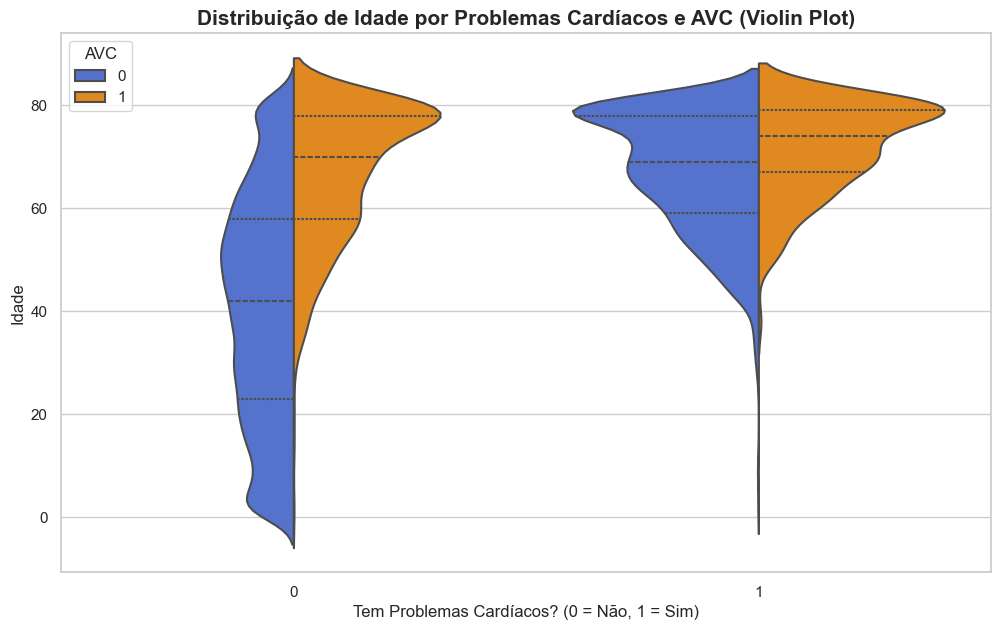

In [22]:
# Usamos o Violin Plot para gerar um gráfico com 3 informações(idade, problemas cardíacos e AVC) para exibir a correlação entre elas.
plt.figure(figsize=(12, 7))

# Criando o Violin Plot
sns.violinplot(
    data=df, 
    x='heart_disease', 
    y='age', 
    hue='stroke', 
    palette=cores_projeto,
    split=True,      
    inner="quartile",
    linewidth=1.5
)

plt.title('Distribuição de Idade por Problemas Cardíacos e AVC (Violin Plot)', fontsize=15, fontweight='bold')
plt.xlabel('Tem Problemas Cardíacos? (0 = Não, 1 = Sim)', fontsize=12)
plt.ylabel('Idade', fontsize=12)
plt.legend(title='AVC', loc='upper left')

plt.show()

A análise deste gráfico indica uma tendência de maior incidência de AVC em indivíduos com problemas cardíacos e idade avançada, um padrão que não ficou evidente na análise cruzada simples. Assim como para hipertensão vamos confirmar a relevância dessas variáveis apresentando a seguir um gráfico de análise proporcional.

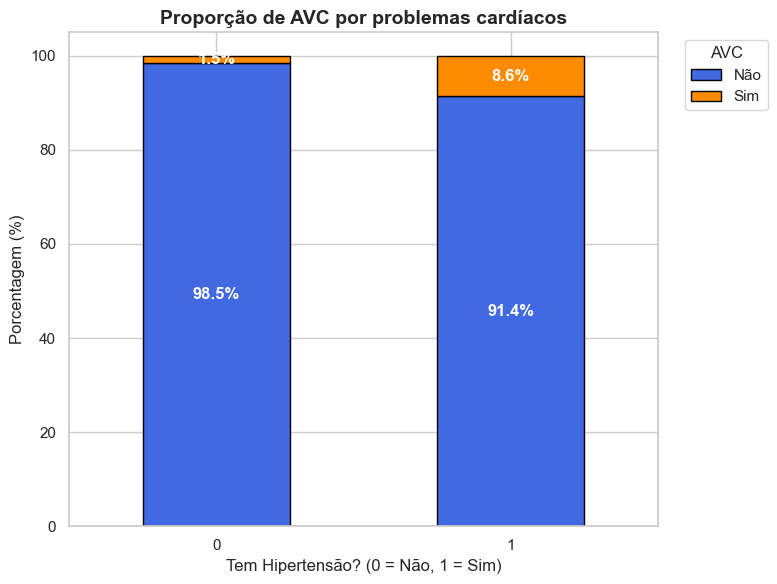

In [23]:
# Criando uma tabela de proporção
prop_data = pd.crosstab(df['heart_disease'], df['stroke'], normalize='index') * 100

# Plotando o gráfico de barras empilhadas
ax = prop_data.plot(
    kind='bar', 
    stacked=True, 
    color=[cores_projeto[0], cores_projeto[1]], 
    figsize=(8, 6), 
    edgecolor='black'
)

plt.title('Proporção de AVC por problemas cardíacos', fontsize=14, fontweight='bold')
plt.xlabel('Tem Hipertensão? (0 = Não, 1 = Sim)')
plt.ylabel('Porcentagem (%)')
plt.legend(title='AVC', labels=['Não', 'Sim'], loc='upper right', bbox_to_anchor=(1.2, 1))
plt.xticks(rotation=0)

# Adicionando os rótulos de porcentagem dentro das barras
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0:
        ax.text(
            x + width/2, 
            y + height/2, 
            f'{height:.1f}%', 
            ha='center', 
            va='center', 
            color='white', 
            fontweight='bold',
            fontsize=12
        )

plt.tight_layout()
plt.show()

Identificou-se que a incidência de AVC é mais de cinco vezes superior em pacientes com histórico de problemas cardíacos em relação aos que não apresentam essa condição. Esse resultado contrasta com as observações da análise inicial, evidenciando uma associação significativamente mais forte entre as variáveis cardíacas e o risco de AVC.

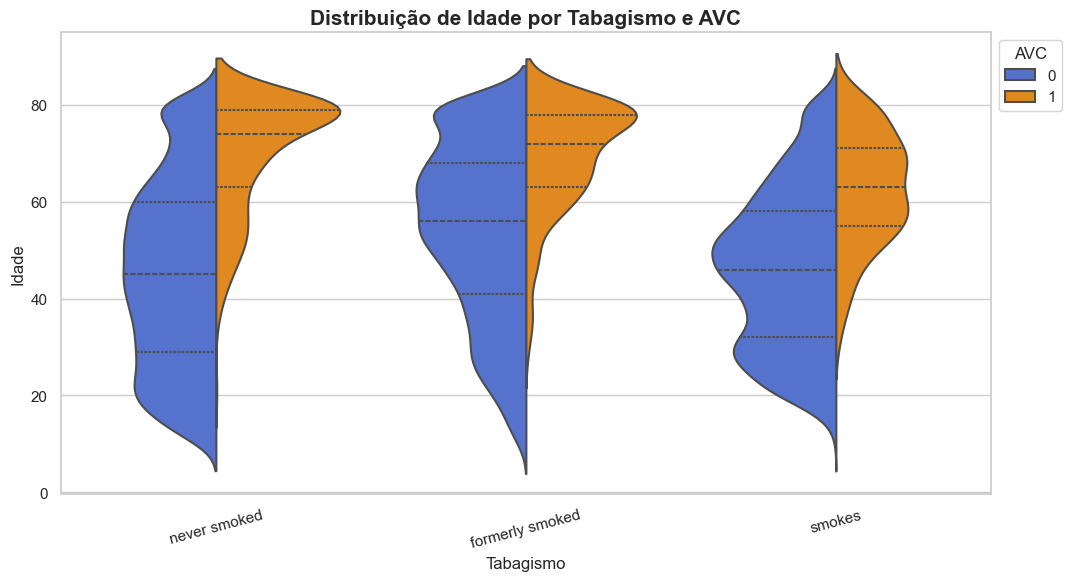

In [27]:
# Usamos o violinplot para gerar um gráfico com 3 informações(Idade, Tabagismo e AVC) para exibir a correlação entre elas.
plt.figure(figsize=(12, 6))

sns.violinplot(
    data=df, 
    x='smoking_status', 
    y='age', 
    hue='stroke', 
    split=True,             
    palette=cores_projeto, 
    inner="quartile",       
    linewidth=1.5
)

plt.title('Distribuição de Idade por Tabagismo e AVC', fontsize=15, fontweight='bold')
plt.xlabel('Tabagismo', fontsize=12)
plt.ylabel('Idade', fontsize=12)
plt.legend(title='AVC', loc='upper left', bbox_to_anchor=(1, 1))

plt.xticks(rotation=15)
plt.show()

A relação entre tabagismo e AVC não ficou muito clara nesse gráfico, pois o peso da idade já pende a proporção de AVC. Por esse motivo vamos gerar o gráfico de proporção para ver se existe alguma correlação não visualizada previamente.

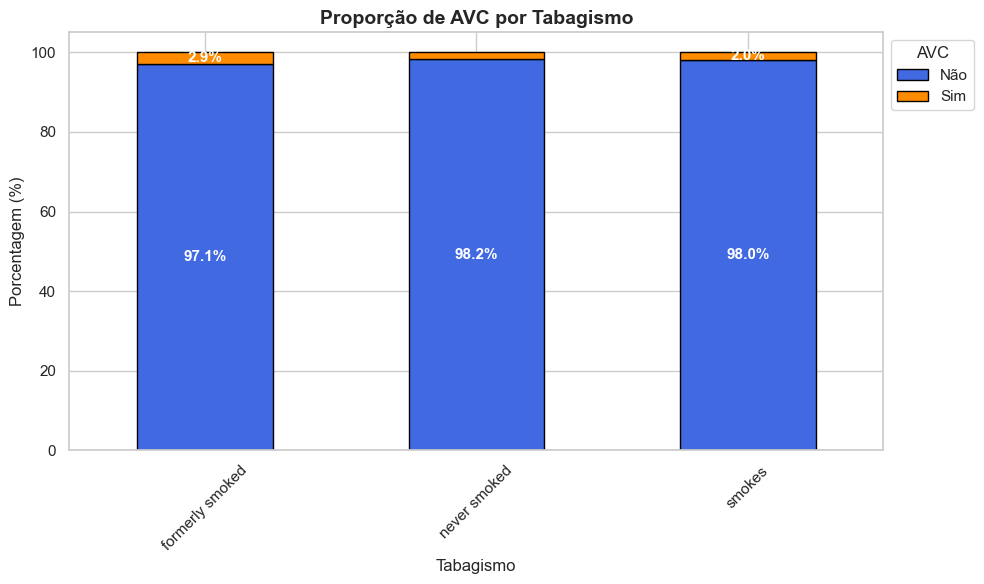

In [28]:
# 1. Criando a tabela de proporção para fumantes
# Usamos normalize='index' para que cada barra (categoria) some 100%
prop_smoking = pd.crosstab(df['smoking_status'], df['stroke'], normalize='index') * 100

# 2. Plotando o gráfico de barras empilhadas
# Usamos as cores_projeto (0: azul, 1: laranja)
ax = prop_smoking.plot(
    kind='bar', 
    stacked=True, 
    color=[cores_projeto[0], cores_projeto[1]], 
    figsize=(10, 6), 
    edgecolor='black'
)

plt.title('Proporção de AVC por Tabagismo', fontsize=14, fontweight='bold')
plt.xlabel('Tabagismo')
plt.ylabel('Porcentagem (%)')
plt.legend(title='AVC', labels=['Não', 'Sim'], loc='upper left', bbox_to_anchor=(1.0, 1))
plt.xticks(rotation=45) # Rotacionamos os nomes para não encavalar

# 3. Adicionando os rótulos de porcentagem
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 2: # Só coloca o texto se a fatia for visível (> 2%)
        ax.text(
            x + width/2, 
            y + height/2, 
            f'{height:.1f}%', 
            ha='center', 
            va='center', 
            color='white', 
            fontweight='bold',
            fontsize=11
        )

plt.tight_layout()
plt.show()

Não identificamos uma correlação relevante entre tabagismo e casos de indivíduos com AVC.

Com isso concluímos as nossas observações dos fatores que clinicamente possuem influências e na análise cruzada simples mostro alta correlação. Daremos andamento ao projeto separando o dataset para treinamento e teste.

### Treinamento de modelos

In [26]:
#separando valores para teste
x = df_model.drop(columns=['stroke'])
y = df_model['stroke']
print(f"Total de características (colunas): {x.shape[1]}")


Total de características (colunas): 15


In [27]:
# Dividindo 70% para treino e 30% para teste
x_train, x_test, y_train, y_test = train_test_split(
    x, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y  # MANTÉM A PROPORÇÃO DE AVC EM AMBOS OS LADOS
)

print(f"Treino: {x_train.shape[0]} amostras")
print(f"Teste: {x_test.shape[0]} amostras")

Treino: 30380 amostras
Teste: 13020 amostras


##### 